In [1]:
import copy
import pickle

import numpy as np
from scipy import constants as cst
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import tqdm
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.P, J_ground=2, F1=3 / 2, F=1
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=1,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=3,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
]

polarizations = [
    [couplings.polarization_Z],
    [couplings.polarization_X, couplings.polarization_Y],
    [couplings.polarization_σm, couplings.polarization_σp]
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [4]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)
v_to_Γ_μ = 0

odepars = lindblad_julia.odeParameters(
    # turn the laser on while traversing past the laser
    # turn the laser off after
    Ω0=(
        "Ωl0 * phase_modulation(t, β, ωphase) *"
        " variable_on_off(t,25e-3*1.5/vz,25e-3*1.5/vz, 0.0)"
    ),
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # J=1 -> J=2 microwaves
    Ω1=1 * hamiltonian.Γ,
    δ1=f"vx*{v_to_Γ_μ}",
    P1="sin(ω1*t + φ1)",
    PX1="P1>0",
    PY1="P1<=0",
    ω1=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # J=2 -> J=3 microwaves
    Ω2=1 * hamiltonian.Γ,
    δ2=f"vx*{v_to_Γ_μ}",
    P2="sin(ω2*t + φ2)",
    Pσm2="P2>0",
    Pσp2="P2<=0",
    ω2=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ2=0.0,  # polarization switching phase [rad]
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [5]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=None,
    decay_channels=None,
    Jmax_X=4,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [6]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 3/2, F = 1>"
states,
"|X, J = 0>",0.484131
"|X, J = 2>",0.515869


In [8]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 1, F₁ = 3/2, F = 1>"
states,
"|X, J = 0, F₁ = 1/2, F = 0>",0.336757
"|X, J = 0, F₁ = 1/2, F = 1>",0.147374
"|X, J = 2, F₁ = 3/2, F = 1>",0.100763
"|X, J = 2, F₁ = 3/2, F = 2>",0.026135
"|X, J = 2, F₁ = 5/2, F = 2>",0.388971


In [9]:
from typing import Sequence, Optional
import numpy.typing as npt
from centrex_tlf.utils.population import thermal_population, J_levels


def generate_thermal_population_states(
    temperature: float,
    QN: Sequence[states.State],
    select: Optional[states.QuantumSelector] = None,
) -> npt.NDArray[np.complex_]:
    levels = len(QN)
    ρ = np.zeros([levels, levels], dtype=complex)

    assert isinstance(QN[0], states.State), "no State objects supplies"

    if select is not None:
        j_levels = np.unique(select.J)
    else:
        j_levels = np.unique(
            [
                qn.largest.J
                for qn in QN
                if qn.largest.electronic_state == states.ElectronicState.X
            ]
        )

    # get the relative thermal population fractions of the ground state
    population = dict(
        [(j, p) for j, p in zip(j_levels, thermal_population(j_levels, temperature))]
    )

    # # get quantum numbers of the ground state
    # quantum_numbers = [
    #     (qn.largest.J, qn.largest.F1, qn.largest.F, qn.largest.mF)
    #     for qn in QN
    #     if qn.largest.electronic_state == states.ElectronicState.X
    # ]

    # assert len(np.unique(quantum_numbers, axis=0)) == len(
    #     quantum_numbers
    # ), "duplicate quantum numbers"

    for idx, qn in enumerate(QN):
        if qn.largest.electronic_state is not states.ElectronicState.X:
            continue
        elif qn.largest.F is None:
            ρ[idx, idx] = population[qn.largest.J]
        else:
            ρ[idx, idx] = population[qn.largest.J] / J_levels(qn.largest.J)

    return ρ

## Indices of various collections of states

In [10]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)
indices_J0_F0 = states.QuantumSelector(
    J=0, F=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J0_F1 = states.QuantumSelector(
    J=0, F=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1_F2 = states.QuantumSelector(
    J=1, F=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2_F3 = states.QuantumSelector(
    J=2, F=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3_F4 = states.QuantumSelector(
    J=3, F=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

## Calculate Rabi rates and population density

In [11]:
ρ = generate_thermal_population_states(
    temperature=6.3,
    QN=obe_system.QN,
)
ρ /= np.trace(ρ)

In [12]:
power = 85e-3  # * 11 / 2  # 11 passes assume zero intensity left after 11 passes
intensity = power / (25.4e-3 * 25.4e-3 * 1.5)
rabi = utils.rabi.intensity_to_rabi(
    intensity, obe_system.couplings[0].main_coupling, D=2.6675506e-30
).real

rabi_microwave_12 = utils.rabi.power_to_rabi_gaussian_beam_microwave(
    power=200e-3,
    coupling=obe_system.couplings[1].main_coupling,
    sigma_x=10.8e-3,
    sigma_y=10.8e-3,
).real

rabi_microwave_23 = utils.rabi.power_to_rabi_gaussian_beam_microwave(
    power=200e-3,
    coupling=obe_system.couplings[2].main_coupling,
    sigma_x=10.8e-3,
    sigma_y=10.8e-3,
).real

## Setup and solve the OBE Problem

In [13]:
odepars.Ωl0 = rabi
odepars.Ω1 = rabi_microwave_12
odepars.ω1 = 2 * np.pi * 1e6
odepars.Ω2 = rabi_microwave_23
odepars.ω2 = 2 * np.pi * 1e6
odepars.ϕ2 = np.pi / 2

# increase tspan to include part with laser off but microwaves on
problem = lindblad_julia.OBEProblem(
    odepars, ρ, tspan=(0, 1.5 * 25.4e-3 * 1.5 / odepars.vz)
)
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

In [14]:
results = lindblad_julia.do_simulation_single(problem, config=config)

0.67 photons


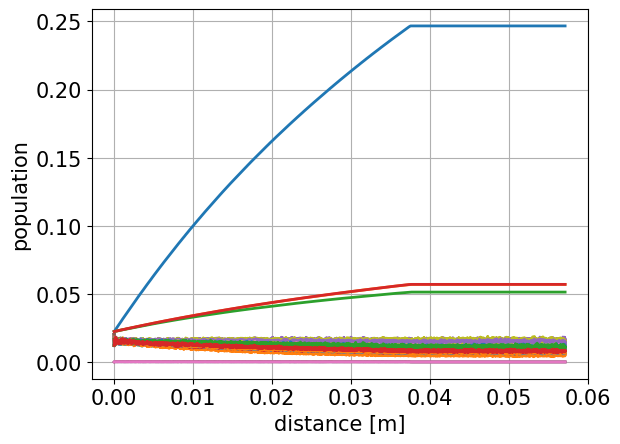

In [15]:
res = copy.deepcopy(results)

labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]
fig, ax = plt.subplots()
ax.plot(res.t * odepars.vz, res.y.T, lw=2, label=np.arange(len(res.y)))
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

# labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

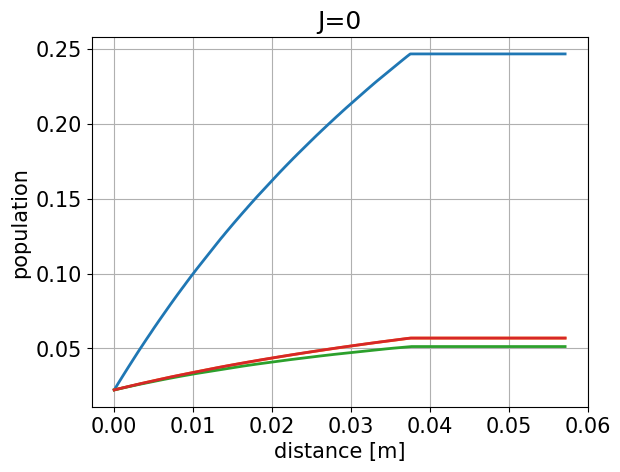

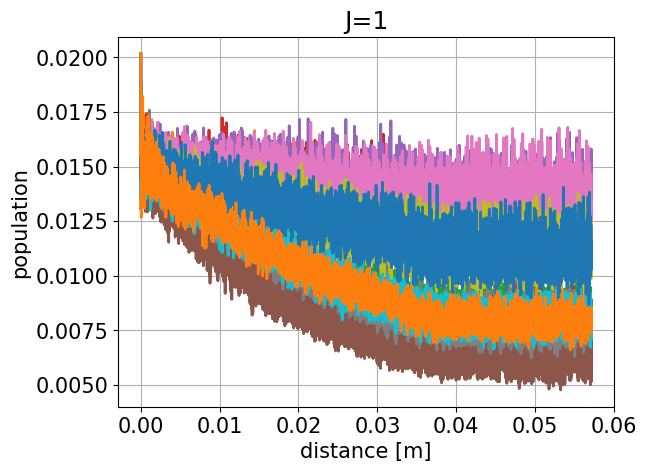

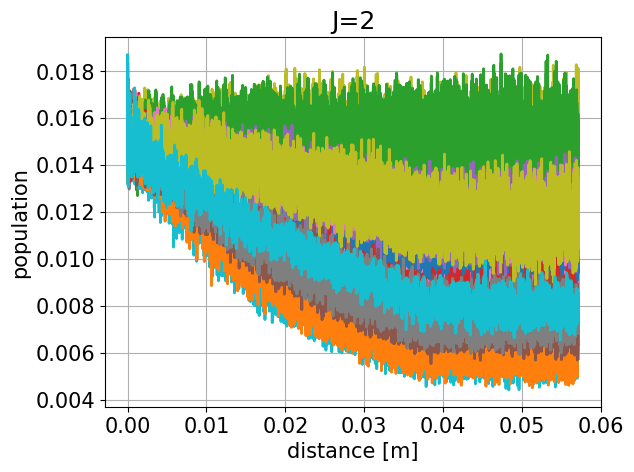

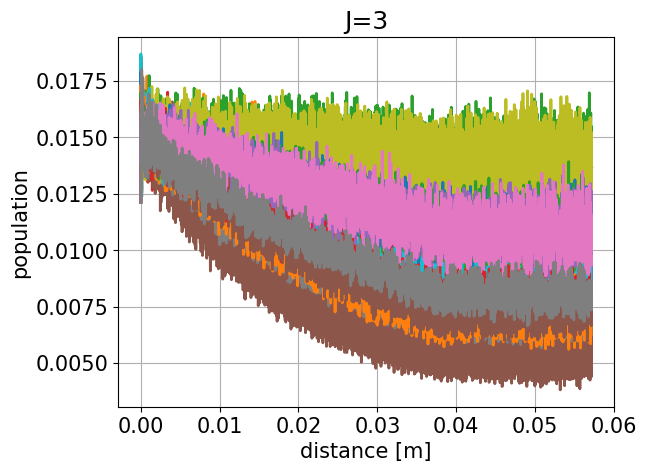

In [16]:
for J, ind in zip([0,1,2,3], [indices_J0, indices_J1, indices_J2, indices_J3]):
    fig, ax = plt.subplots()
    ax.plot(res.t * odepars.vz, res.y[ind].T, lw=2)
    ax.set_xlabel("distance [m]")
    ax.set_ylabel("population")
    ax.set_title(f"J={J}")
    ax.grid(True)

In [17]:
gain_J0_F1 = (
    results.y[indices_J0_F1].sum(axis=0)[-1] / results.y[indices_J0_F1].sum(axis=0)[0]
)
gain_J0_F0 = (
    results.y[indices_J0_F0].sum(axis=0)[-1] / results.y[indices_J0_F0].sum(axis=0)[0]
)

print(f"gain J=0 F=0 from simulation → {gain_J0_F0:>4.1f}")
print(f"gain J=0 F=1 from simulation → {gain_J0_F1:>4.1f}")

gain J=0 F=0 from simulation → 11.1
gain J=0 F=1 from simulation →  2.5


In [18]:
depletion_J1_F2 = results.y[indices_J1_F2][:, -1] / results.y[indices_J1_F2][:, 0]
print(f"depletion J=1 F=2 from R(1) F=3 → {depletion_J1_F2.mean():.2f}")

depletion_J2_F3 = results.y[indices_J2_F3][:, -1] / results.y[indices_J2_F3][:, 0]
print(f"depletion J=2 F=3 from R(2) F=4 → {depletion_J2_F3.mean():.2f}")

depletion_J3_F4 = results.y[indices_J3_F4][:, -1] / results.y[indices_J3_F4][:, 0]
print(f"depletion J=3 F=4 from R(3) F=5 → {depletion_J3_F4.mean():.2f}")

depletion J=1 F=2 from R(1) F=3 → 0.46
depletion J=2 F=3 from R(2) F=4 → 0.57
depletion J=3 F=4 from R(3) F=5 → 0.75


In [19]:
depletion_J1 = results.y[indices_J1][:, -1] / results.y[indices_J1][:, 0]
print(f"depletion J=1 from simulation → {depletion_J1.mean():.2f}")

depletion_J2 = results.y[indices_J2][:, -1] / results.y[indices_J2][:, 0]
print(f"depletion J=2 from simulation → {depletion_J2.mean():.2f}")

depletion_J3 = results.y[indices_J3][:, -1] / results.y[indices_J3][:, 0]
print(f"depletion J=3 from simulation → {depletion_J3.mean():.2f}")

depletion J=1 from simulation → 0.50
depletion J=2 from simulation → 0.59
depletion J=3 from simulation → 0.80


In [20]:
br_df = couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)
br_J0_F0, br_J0_F1, *_ = br_df.values.flatten()

def gain_J0_F1_from_depletion(depletion: npt.NDArray[np.float_], T: float) -> float:
    p = thermal_population(J=np.array([0, 1, 2, 3]), T=T)
    population_to_transfer = ((depletion) * p[1:]).sum()
    factor_to_J0_F1 = br_J0_F1 / (br_J0_F1 + br_J0_F0)
    initial_population = p[0] / J_levels(0) * 3
    gain = (
        initial_population + factor_to_J0_F1 * population_to_transfer
    ) / initial_population
    return gain

In [24]:
gain_J0_F1_high_F = gain_J0_F1_from_depletion(
    np.array(
        [
            1 - depletion_J1_F2.mean(),
            1 - depletion_J2_F3.mean(),
            1 - depletion_J3_F4.mean(),
        ]
    ),
    T=6.3,
)
print(
    f"gain J=0 F=1 from depletion J=1 F=2, J=2 F=3, J=3 F=4 → {gain_J0_F1_high_F:.1f}"
)
print(f"gain J=0 F=1 from simulation → {gain_J0_F1:>4.1f}")

gain J=0 F=1 from depletion J=1 F=2, J=2 F=3, J=3 F=4 → 2.6
gain J=0 F=1 from simulation →  2.5


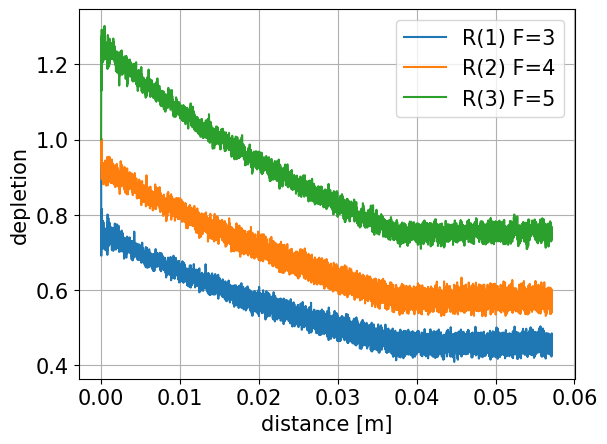

In [22]:
fig, ax = plt.subplots()

ax.plot(
    res.t * odepars.vz,
    (
        results.y[indices_J1_F2][:, :] / results.y[indices_J1_F2][:, 0][:, np.newaxis]
    ).mean(axis=0),
    label = "R(1) F=3"
)
ax.plot(
    res.t * odepars.vz,
    (
        results.y[indices_J2_F3][:, :] / results.y[indices_J2_F3][:, 0][:, np.newaxis]
    ).mean(axis=0),
    label = "R(2) F=4"
)
ax.plot(
    res.t * odepars.vz,
    (
        results.y[indices_J3_F4][:, :] / results.y[indices_J3_F4][:, 0][:, np.newaxis]
    ).mean(axis=0),
    label = "R(3) F=5"
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("depletion")
ax.legend()
ax.grid(True)

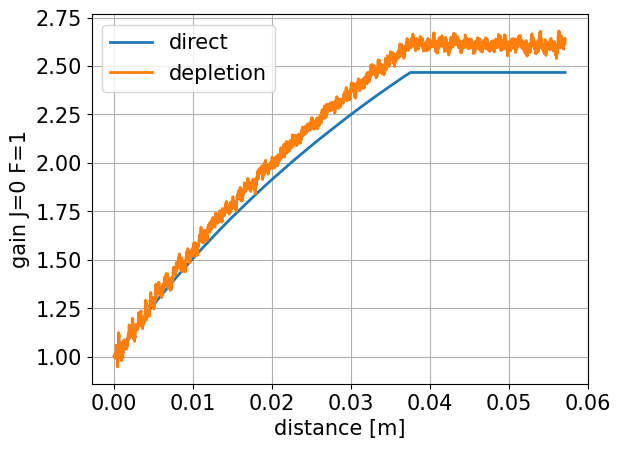

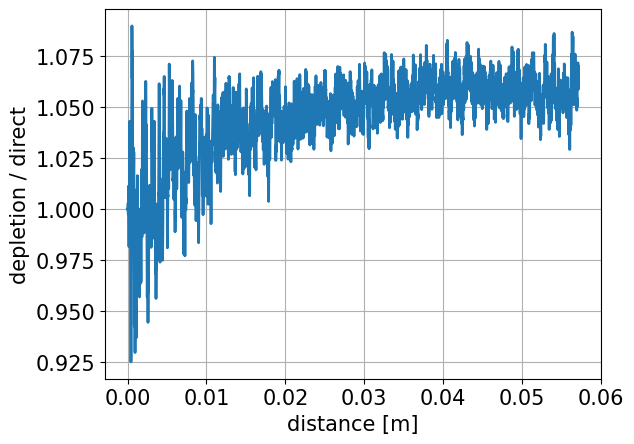

In [23]:
y1 = results.y[indices_J1_F2][:, :] / results.y[indices_J1_F2][:, 0][:, np.newaxis]
y2 = results.y[indices_J2_F3][:, :] / results.y[indices_J2_F3][:, 0][:, np.newaxis]
y3 = results.y[indices_J3_F4][:, :] / results.y[indices_J3_F4][:, 0][:, np.newaxis]

y = np.array(
    [
        gain_J0_F1_from_depletion(
            np.array(
                [
                    1 - yi1,
                    1 - yi2,
                    1 - yi3,
                ]
            ),
            T=6.3,
        )
        for yi1, yi2, yi3 in zip(y1.mean(axis=0), y2.mean(axis=0), y3.mean(axis=0))
    ]
)

direct = (
    results.y[indices_J0_F1].sum(axis=0)[:] / results.y[indices_J0_F1].sum(axis=0)[0]
)

fig, ax = plt.subplots()

ax.plot(
    res.t * odepars.vz,
    direct,
    lw=2,
    label="direct",
)
ax.plot(
    res.t * odepars.vz,
    y,
    lw=2,
    label="depletion",
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("gain J=0 F=1")
ax.legend()
ax.grid(True)

fig,ax=plt.subplots()

ax.plot(
    res.t * odepars.vz,
    y/direct,
    lw=2,
    label="depletion",
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("depletion / direct")

ax.grid(True)

Some small oscillation (Rabi) but not changing the actual populations noticably.